# Chunking Fiqa Dataset
In this Notebook I will analyse the Fiqa Dataset and transform it to apply some chunking strategies

## Chunking Considerations
- **What kind of Data are we working with?**
    - size of content (long document like articles or book, or shorter content like tweets or messages)
    - structure of content (plain text, code, tables,...)
- **Which embedding model are we using and what chunk size does it perform optimally on?**
- **How will the user queries look like?**
    - Short and specific or long and complex
- **How will the retrieved results be use?**
    - e.g. sematic search, question answering, summarization

### Papers
- [Pinecone: Chunking Strategies](https://www.pinecone.io/learn/chunking-strategies/)
- [Paper about Financial Report Chunking for RAG](https://arxiv.org/html/2402.05131v2)


In [ ]:
# Load enviroment variables
# import os
# from dotenv import load_dotenv

# os.environ.get('OPENAI_API_KEY') d


## Analysis
The Fiqa Dataset is a long text dataset. It is already divided into rows.

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

/home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of Rows (Chunks): 57638
Length of Rows:  [16990, 13604, 13080, 10643, 10506, 10276, 10082, 10054, 9683, 9503, 9437, 9363, 9317, 9185, 9140, 9093, 9085, 9023, 8946, 8937, 8663, 8633, 8608, 8377, 8348, 8294, 8193, 8132, 8068, 7992, 7954, 7850, 7624, 7607, 7552, 7550, 7515, 7511, 7510, 7498, 7478, 7407, 7356, 7342, 7334, 7333, 7289, 7261, 7260, 7250, 7242, 7222, 7213, 7171, 7166, 7116, 7011, 6992, 6987, 6982, 6941, 6941, 6936, 6915, 6878, 6856, 6834, 6773, 6743, 6714, 6691, 6665, 6649, 6642, 6639, 6626, 6620, 6619, 6583, 6530, 6522, 6513, 6512, 6498, 6480, 6438, 6437, 6419, 6412, 6406, 6397, 6385, 6365, 6353, 6300, 6265, 6257, 6200, 6191, 6146, 6146, 6061, 6035, 6032, 6030, 6004, 5992, 5987, 5947, 5927, 5925, 5924, 5923, 5901, 5887, 5875, 5871, 5844, 5809, 5789, 5781, 5770, 5765, 5765, 5757, 5729, 5711, 5706, 5702, 5701, 5695, 5691, 5689, 5676, 5661, 5660, 5644, 5644, 5640, 5635, 5634, 5626, 5622, 5613, 5604, 5588, 5584, 5571, 5566, 5546, 5527, 5522, 5512, 5509, 5502, 5457, 5451, 5

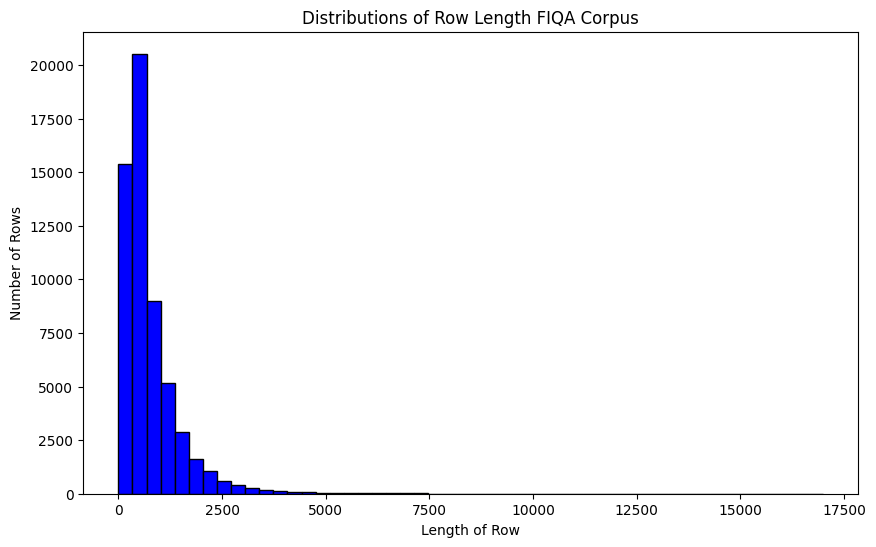

In [2]:
fiqa_corpus = load_dataset("explodinggradients/fiqa", "corpus")

print('Number of Rows (Chunks):' , len(fiqa_corpus['corpus']['doc']))

length_of_rows = []
for doc in fiqa_corpus['corpus']['doc']:
    length_of_rows.append(len(doc))

length_of_rows.sort(reverse=True)
# len function counts number of characters
print('Length of Rows: ', length_of_rows)

plt.figure(figsize=(10, 6))  
plt.hist(length_of_rows, bins=50, color='blue', edgecolor='black')  

plt.title('Distributions of Row Length FIQA Corpus')
plt.xlabel('Length of Row')
plt.ylabel('Number of Rows')

plt.show()



We can see that the size of the rows vary a lot and some are very long. So we need to get the full text and rechunk the data so we have a clean chunking strategy.

*Maybe analyze also the content of some chunks or just view the [dataset](https://huggingface.co/datasets/explodinggradients/fiqa).*

**Embed chunks and store into ChromaDB Vectorstore**

In [13]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.docstore.document import Document

vectorstore = Chroma(persist_directory='../vectorstores/original_chunks', embedding_function=OpenAIEmbeddings(model='text-embedding-3-small'))
corpus_len = len(fiqa_corpus['corpus'])

for index, doc in enumerate(fiqa_corpus["corpus"]):
    # log.info(f"Processing document {index + 1} of {corpus_len}")
    doc = Document(page_content=doc["doc"], metadata={"source": "local", "id": index})
    vectorstore.add_documents([doc])


- Duration for embeddings: 282 min
- Costs for embeddings: 0,20 $

## Chunking

First, I will convert the Fiqa Dataset I downloaded as csv to a text file, because for me it is easier to handle with text files.
In the text file each row will be in an new line.

In [ ]:
import csv
with open("../fiqa_dataset/corpus.txt", "w") as my_output_file:
    with open("../fiqa_dataset/corpus.csv", "r") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

In [3]:
with open("../fiqa_dataset/corpus.txt") as f:
    fiqa_corpus = f.read()

### Fixed-size chunking
- we decide how big each chunk should be and whether there should be an overlap between them to keep a little semantic context
- computatially cheap and simple

#### Chunksize 1000 and overlap 200

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [14]:
text_splitter = RecursiveCharacterTextSplitter(
    separators = [".", "\n", "\n\n"],
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False
)

texts = text_splitter.create_documents([fiqa_corpus])


In [ ]:
print('Number of Chunks: ', len(texts))

length_of_chunks = []
for doc in texts:
    length_of_chunks.append(len(doc.page_content))

length_of_chunks.sort(reverse=True)

print('Length of Chunks: ', length_of_chunks)

plt.figure(figsize=(10, 6))  
plt.hist(length_of_chunks, bins=50, color='blue', edgecolor='black')  

plt.title('Fixed Size Chunking (1000)')
plt.xlabel('Length of Chunks')
plt.ylabel('Number of Chunks')

plt.show()


In [ ]:
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Create an instance of OpenAIEmbeddings
embedding_function = OpenAIEmbeddings(model='text-embedding-3-small')

# Use the Chroma.from_documents class method with keyword arguments
vectorstore_1000 = Chroma.from_documents(
    texts, 
    embedding_function,
    persist_directory='../vectorstores/fixed_size_1000'
)

- took only 15 min

#### Chunksize 1500 and overlap 300

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    separators = [".", "\n", "\n\n"],
    chunk_size=1500,
    chunk_overlap=300,
    length_function=len,
    is_separator_regex=False
)

texts = text_splitter.create_documents([fiqa_corpus])

In [ ]:
print('Number of Chunks: ', len(texts))

length_of_chunks = []
for doc in texts:
    length_of_chunks.append(len(doc.page_content))

length_of_chunks.sort(reverse=True)

print('Length of Chunks: ', length_of_chunks)

plt.figure(figsize=(10, 6))  
plt.hist(length_of_chunks, bins=50, color='blue', edgecolor='black')  

plt.title('Fixed Size Chunking (1000)')
plt.xlabel('Length of Chunks')
plt.ylabel('Number of Chunks')

plt.show()

In [13]:
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Create an instance of OpenAIEmbeddings
embedding_function = OpenAIEmbeddings(model='text-embedding-3-small')

# Use the Chroma.from_documents class method with keyword arguments
vectorstore = Chroma.from_documents(
    texts, 
    embedding_function,
    persist_directory='../vectorstores/fixed_size_1500'
)

/home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


#### Chunksize 2000 and overlap 400

In [20]:
text_splitter = RecursiveCharacterTextSplitter(
    separators = [".", "\n", "\n\n"],
    chunk_size=2000,
    chunk_overlap=400,
    length_function=len,
    is_separator_regex=False
)

texts = text_splitter.create_documents([fiqa_corpus])

In [ ]:
print('Number of Chunks: ', len(texts))

length_of_chunks = []
for doc in texts:
    length_of_chunks.append(len(doc.page_content))

length_of_chunks.sort(reverse=True)

print('Length of Chunks: ', length_of_chunks)

plt.figure(figsize=(10, 6))  
plt.hist(length_of_chunks, bins=50, color='blue', edgecolor='black')  

plt.title('Fixed Size Chunking (1000)')
plt.xlabel('Length of Chunks')
plt.ylabel('Number of Chunks')

plt.show()

In [22]:
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Create an instance of OpenAIEmbeddings
embedding_function = OpenAIEmbeddings(model='text-embedding-3-small')

# Use the Chroma.from_documents class method with keyword arguments
vectorstore_2000 = Chroma.from_documents(
    texts, 
    embedding_function,
    persist_directory='../vectorstores/fixed_size_2000'
)

**First evaluation**
- {'answer_relevancy': 0.3993, 'answer_correctness': 0.2876, 'context_recall': 0.4284, 'context_relevancy': 0.0443}

### Semantic Chunking

In [1]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

text_splitter = SemanticChunker(OpenAIEmbeddings(model='text-embedding-3-small'))

In [ ]:
docs = text_splitter.create_documents([fiqa_corpus])

In [ ]:
vectorstore_semantic = Chroma.from_documents(
    docs, 
    embedding_function,
    persist_directory='../vectorstores/semantic_chunks'
)